# Εργασία 1

## Α. Αναγνώριση μονών και ζυγών αριθμών στα δεκαδικά ψηφία της MNIST

### 1. Προετοιμασία των δεδομένων

Σκοπός της εργασίας είναι η αξιολόγηση μοντέλων τα οποία κατηγοριοποιούν εικόνες από χειρόγραφα ψηφία σε μονούς και ζυγούς αριθμούς.

Παρακάτω βλέπουμε τις εκδόσεις της python και των βιβλιοθηκών που χρησιμοποιήθηκαν στην εργασία.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn
import cvxopt
import sys

print('Python version:', sys.version)
print('scikit-learn version:', sklearn.__version__)
print('numpy version:', np.__version__)
print('matplotlib version:', matplotlib.__version__)
print('pandas version', pd.__version__)
print('cvxopt version', cvxopt.__version__)

Python version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
scikit-learn version: 0.23.2
numpy version: 1.19.2
matplotlib version: 3.3.2
pandas version 1.1.3
cvxopt version 1.2.0


Τα δεδομένα περιέχονται στο αρχείο mnist_all.mat. Το διάβασμα του αρχείου γίνεται με την συνάρτηση scipy.io.loadmat η οποία επιστρέφει ένα dictionary το οποίο έχει κλειδια τα 'train0', 'train1', 'train2',... και 'test0', 'test1', 'test2',... και data τις εικόνες των αντίστοιχων ψηφίων.

In [2]:
import scipy.io
import urllib.request
import os

np.random.seed(0)

url = 'https://cs.nyu.edu/~roweis/data/mnist_all.mat'
filename = 'mnist_all.mat'

if not os.path.exists(filename):
    print('Downloading file...')
    urllib.request.urlretrieve(url, filename)
    print('Done.')

mat = scipy.io.loadmat(filename)
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'train0', 'test0', 'train1', 'test1', 'train2', 'test2', 'train3', 'test3', 'train4', 'test4', 'train5', 'test5', 'train6', 'test6', 'train7', 'test7', 'train8', 'test8', 'train9', 'test9'])

Οι εικόνες των ψηφίων έχουν μέγεθος 784 = 28x28.

In [3]:
digit = mat['train2'][0]
digit.shape

(784,)

Παρακάτω φαίνονται οι εικόνες πέντε ψηφίων.

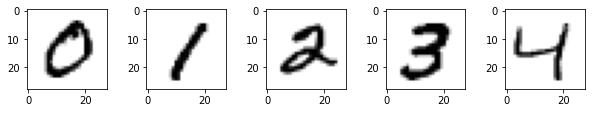

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 5
fig, axs = plt.subplots(1, n, figsize=(10, 10))
plt.subplots_adjust(wspace=0.5)
for i in range(n):
    digit = mat['train' + str(i)][0]
    digit = digit.reshape((28, 28))
    axs[i].imshow(digit, cmap=plt.cm.binary)
plt.show()

Οι είκονες και οι ετικέτες φορτώνονται σε numpy arrays. Το μέγεθος του training set είναι 60000 και του test set 10000. Η κανονικοποίηση στο διάστημα [0, 1] γίνεται με διαίρεση με το 255 το οποίο είναι η μέγιστη τιμή της φωτεινότητας ενός pixel.

In [5]:
x_train, y_train, x_test, y_test = [], [], [], []

for key, data in mat.items():
    if 'train' in key:
        for x in data:
            x_train.append(x)
            num = int(key[-1])
            y_train.append(num)
    if 'test' in key:
        for x in data:
            x_test.append(x)
            num = int(key[-1])
            y_test.append(num)

x_train = np.array(x_train, dtype=np.double)
y_train = np.array(y_train, dtype=np.double)
x_test = np.array(x_test, dtype=np.double)
y_test = np.array(y_test, dtype=np.double)
x_test_original = x_test

print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (60000, 784)
y_train.shape = (60000,)
x_test.shape = (10000, 784)
y_test.shape = (10000,)


In [6]:
x_train = x_train/255.
x_test = x_test/255.

print()
print('x_train is in [{}, {}]'.format(np.min(x_train), np.max(x_train)))
print('x_test is in [{}, {}]'.format(np.min(x_test), np.max(x_test)))


x_train is in [0.0, 1.0]
x_test is in [0.0, 1.0]


Το παρακάτω ιστόγραμμα μας δείχνει ότι οι κλάσεις των ψηφίων είναι ζυγισμένες. 

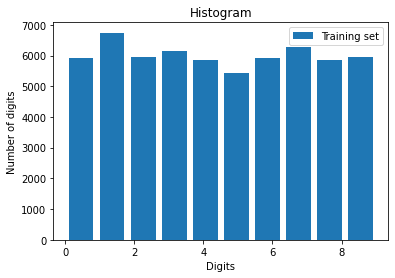

In [7]:
plt.hist(y_train, label='Training set', rwidth=0.8)
plt.title('Histogram')
plt.ylabel('Number of digits')
plt.xlabel('Digits')
plt.legend()
plt.show()

Λόγω του μεγάλου μεγέθους των δεδομένων, ως μέθοδος αξιολόγησης των μοντέλων, για την επιλογή των παραμέτρων τους, επιλέγεται η διαστρωματωμένη παρακράτηση (stratified holdout). Χρησιμοποιώντας αυτή τη μέθοδο χωρίζεται το training set ξανά σε training set και validation set διασφαλίζοντας ότι η κατανομή των κλάσεων παραμένει η ίδια και στα δύο set. Έτσι όλα τα ψηφία αντιπροσωπεύονται ισάξια.

In [8]:
from sklearn import model_selection

x_train_all = x_train
y_train_all = y_train

split = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)

for train_index, val_index in split.split(x_train_all, y_train_all):
    x_train, y_train = x_train_all[train_index], y_train_all[train_index]
    x_val, y_val = x_train_all[val_index], y_train_all[val_index]

print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_val.shape =', x_val.shape)
print('y_val.shape =', y_val.shape)

x_train.shape = (36000, 784)
y_train.shape = (36000,)
x_val.shape = (24000, 784)
y_val.shape = (24000,)


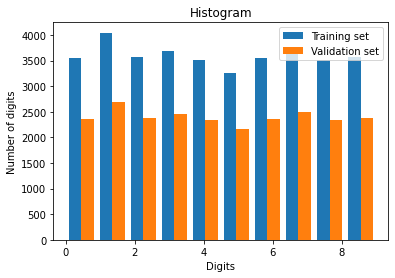

In [9]:
plt.hist((y_train, y_val), label=('Training set', 'Validation set'), rwidth=0.8)
plt.title('Histogram')
plt.ylabel('Number of digits')
plt.xlabel('Digits')
plt.legend()
plt.show()

Αλλάζουμε τις ετικέτες σε -1 και 1 έτσι ώστε να αντιπροσωπεύουν τους ζυγούς και τους μονούς αριθμούς αντίστοιχα.

In [10]:
y_train = y_train % 2
y_val = y_val % 2
y_test = y_test % 2

y_train[y_train == 0] = -1.0
y_val[y_val == 0] = -1.0
y_test[y_test == 0] = -1.0

### 2. Υλοποίηση αλγορίθμων

Υλοποιήθηκαν αλγόριθμοι για SVM, kPCA και LDA οι οποίοι συγκρίνονται με τους αντίστοιχους της sklearn.

#### 2.1 My SVM

Ακολουθεί υλοποίηση ενός SVM classifier με linear kernel. Ο Quadratic Programming solver της βιβλιοθήκης CVXOPT υπολογίζει τους πολλαπλασιαστές Lagrange του δυϊκού προβλήματος του SVM.

In [18]:
from cvxopt import matrix, solvers

class MySVM(object):
    def __init__(self, C=1.0, kernel='linear', degree=3, gamma='scale', coef0=0.0):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.sv_x = None
        self.sv_y = None
        self.alphas = None
        self.b = 0
    
    def set_params(self, **params):
        if not params:
            return self
        self.C = params.get('C', self.C)
        self.kernel = params.get('kernel', self.kernel)
        self.degree = params.get('degree', self.degree)
        self.gamma = params.get('gamma', self.gamma)
        self.coef0 = params.get('coef0', self.coef0)
        return self
    
    def _linear_kernel(self, X, Z):
        return np.matmul(X, Z.T)
    
    def _poly_kernel(self, X, Z):
        return np.power(self.gamma*np.matmul(X, Z.T) + self.coef0, self.degree)

    def _rbf_kernel(self, X, Z):
        n = X.shape[0]
        m = Z.shape[0]
        XX = np.dot(np.sum(np.power(X, 2), 1).reshape(n, 1), np.ones((1, m)))
        ZZ = np.dot(np.sum(np.power(Z, 2), 1).reshape(m, 1), np.ones((1, n)))     
        return np.exp(-self.gamma*(XX + ZZ.T - 2 * np.dot(X, Z.T)))
    
    def _kernel(self, X, Z):
        if self.kernel == 'linear':
            return self._linear_kernel(X, Z)
        elif self.kernel == 'poly':
            return self._poly_kernel(X, Z)
        elif self.kernel == 'rbf':
            return self._rbf_kernel(X, Z)
        else:
            raise Exception('Invalid kernel')
    
    def fit(self, X, y):
        # Convert the problem to a Quadratic Programming problem of the form:
        # minimize (1/2)(x.T)Px + (q.T)x
        # s.t Gx <= h, Ax = b
        
        m, n = X.shape
        
        if self.kernel in ('poly', 'rbf'):
            if self.gamma == 'scale':
                self.gamma = 1./(n*X.var())
            elif self.gamma == 'auto':
                self.gamma = 1./n
        
        K = self._kernel(X, X)
        y = y.reshape(-1, 1)
        P = matrix(np.matmul(y, y.T)*K)
        q = matrix(-np.ones((m, 1)))
        A = matrix(y.reshape(1, -1))
        b = matrix(np.zeros(1))
        G = matrix(np.vstack((-np.eye(m), np.eye(m))))
        h = matrix(np.hstack((np.zeros(m), self.C*np.ones(m))))
        
        # Run Quadratic Programming Solver
        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(solution['x'])
        
        # Get support vectors
        if self.kernel == 'poly':
            tol = 1e-2
        elif self.kernel == 'rbf':
            tol = 1e-2
        else:
            tol = 1e-4
            
        i = (alphas > tol).flatten()
        
        #print('Support vectors:', np.sum(i))
        
        self.sv_x = X[i]
        self.sv_y = y[i]
        self.alphas = alphas[i]
        
        # Calculate bias term
        if len(self.alphas) > 0:
            self.b = self.sv_y - np.sum(self._kernel(self.sv_x, self.sv_x)*self.alphas*self.sv_y, axis=0)
            self.b = np.sum(b)/self.b.size
    
    def predict(self, X):
        if len(self.alphas) == 0:
            return np.ones(X.shape[0])
        return np.sign(np.sum(self._kernel(self.sv_x, X)*self.alphas*self.sv_y, axis=0) + self.b)

#### 2.2 My kPCA

Ο αλγόριθμος kPCA υλοποιήθηκε για polynomial και rbf kernel. Υπολόγίζεται πρώτα ο centralized gramian matrix στον οποίο πραγματοποιείται ιδιοανάλυση. Οι ιδιοτιμές και τα ιδιοδιανύσματα ταξινομούνται απο τη μεγαλύτερη στην μικρότερη ιδιοτιμή και επιλέγονται αυτά που αντιστοιχούν σε μη μηδενικές ιδιοτιμές. Αυτά τα ιδιοδιανύσματα αποτελούν την βάση του καινούριου χώρου στον οποίο προβάλλονται τα δείγματα.

In [ ]:
from sklearn.preprocessing import KernelCenterer

class MyKernelPCA(object):
    def __init__(self, kernel='linear', gamma=None, degree=3, coef0=1.0):
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.v = None
        self.w = None
        self.X_fit = None
        self.centerer = KernelCenterer()
    
    def set_params(self, **params):
        if not params:
            return self
        self.kernel = params.get('kernel', self.kernel)
        self.gamma = params.get('gamma', self.gamma)
        self.degree = params.get('degree', self.degree)
        self.coef0 = params.get('coef0', self.coef0)
        return self
    
    def _linear_kernel(self, X, Z):
        return np.matmul(X, Z.T)
    
    def _poly_kernel(self, X, Z):
        return (self.gamma*np.matmul(X, Z.T) + self.coef0)**self.degree

    def _rbf_kernel(self, X, Z):
        n = X.shape[0]
        m = Z.shape[0]
        XX = np.matmul(np.sum(X**2, 1).reshape(n, 1), np.ones((1, m)))
        ZZ = np.matmul(np.sum(Z**2, 1).reshape(m, 1), np.ones((1, n)))
        return np.exp(-self.gamma*(XX + ZZ.T - 2*np.matmul(X, Z.T)))
    
    def _kernel(self, X, Y):
        if self.kernel == 'linear':
            return self._linear_kernel(X, Y)
        elif self.kernel == 'poly':
            return self._poly_kernel(X, Y)
        elif self.kernel == 'rbf':
            return self._rbf_kernel(X, Y)
        else:
            raise Exception('Invalid kernel')
    
    def _fix_eigenvalues(self, w):
        w = np.array(w)
        tol_factor = 1e-12 if w.dtype == np.float64 else 2e-7
        tol = max(w)*tol_factor
        w[w < tol] = 0.0
        return w
    
    def fit(self, X, y=None):
        self.X_fit = X
        m, n = X.shape
        if self.kernel in ('poly', 'rbf'):
            if self.gamma is None:
                self.gamma = 1./n
        K = self._kernel(X, X)
        K = self.centerer.fit_transform(K)
        w, v = scipy.linalg.eigh(K)
        w = self._fix_eigenvalues(w)
        indices = w.argsort()[::-1]
        v = v[:, indices]
        w = w[indices]
        non_zeros = w > 0.0
        v = v[:, non_zeros]
        w = w[non_zeros]
        self.v = v
        self.w = w
        return self

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.v * np.sqrt(self.w)
    
    def transform(self, X):
        K = self._kernel(X, self.X_fit)
        K = self.centerer.transform(K)
        return np.dot(K, self.v/np.sqrt(self.w))

#### 2.3 My LDA

Υλοποιήθηκε αλγόριθμος Linear Discriminant Analysis. Υπολόγίζεται ο within scatter matrix Sw και ο between scatter matrix Sb. Έπειτα επιλύεται το γενικεύμενο πρόβλημα ιδιοτιμών για τους πίνακες Sb και Sw. Οι ιδιοτιμές και τα ιδιοδιανύσματα ταξινομούνται απο τη μεγαλύτερη στην μικρότερη ιδιοτιμή και επιλέγονται οι πρώτες n-1, όπου n ο αριθμός των κλάσεων. Αυτά τα ιδιοδιανύσματα αποτελούν την βάση του καινούριου χώρου στον οποίο προβάλλονται τα δείγματα.

In [3]:
class MyLinearDiscriminantAnalysis(object):
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.max_components = 0
        self.v = None
        self.w = None
    
    def set_params(self, **params):
        if not params:
            return self
        self.n_components = params.get('n_components', self.n_components)
        return selfβ
    
    def fit(self, X, y):
        d = X.shape[1]
        labels, y_t = np.unique(y, return_inverse=True)
        priors = np.bincount(y_t) / float(len(y))
        n_labels = len(labels)
        mean_vecs = np.zeros((n_labels, d))
        for i, label in enumerate(labels):
            mean_vecs[i] = np.mean(X[y==label], axis=0)
        
        Sw = np.zeros((d, d))
        for i, label in enumerate(labels):
            Sw += priors[i]*np.cov(X[y==label].T, bias=1)
        
        Sb = np.zeros((d, d))
        m = np.mean(mean_vecs, axis=0).reshape(d, 1)
        for i, label in enumerate(labels):
            Ni = X[y==label].shape[0]
            mi = mean_vecs[i].reshape(d, 1)
            mi_m = mi - m
            Sb += Ni * np.dot(mi_m, mi_m.T)
               
        w, v = scipy.linalg.eigh(Sb, Sw)
        indices = w.argsort()[::-1]
        self.v = v[:, indices]
        self.w = w[indices]
        
        if self.n_components is None:
            self.max_components = min(n_labels - 1, d)
        else:
            self.max_components = self.n_components
        
        return self
    
    def transform(self, X):
        return np.dot(X, self.v[:, :self.max_components])

### 3. Μείωση διαστάσεων

Γίνεται μείωση των διαστάσεων με την τεχνική PCA διατηρώντας το 90% της διασποράς. Η διάσταση των δεδομένων μειώνεται από 784 σε 87.

In [11]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=0.9, svd_solver='full', random_state=0)
x_train = pca.fit_transform(x_train)
x_val = pca.transform(x_val)
x_test = pca.transform(x_test)

x_train_all = np.concatenate((x_train, x_val))
y_train_all = np.concatenate((y_train, y_val))

print('x_train_all.shape =', x_train_all.shape)
print('x_train.shape =', x_train.shape)
print('x_val.shape =', x_val.shape)
print('x_test.shape =', x_test.shape)

x_train_all.shape = (60000, 87)
x_train.shape = (36000, 87)
x_val.shape = (24000, 87)
x_test.shape = (10000, 87)


Οι κλάσεις δεν φαίνονται διαχωρίσιμες στο επίπεδο των δυο πρώτων ιδιοδιανυσμάτων.

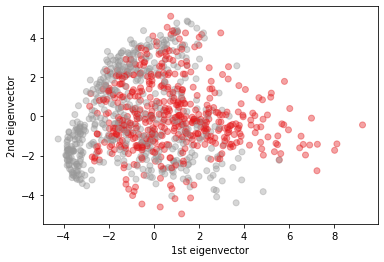

In [12]:
plt.scatter(x_train[:1000, 0], x_train[:1000, 1], c=y_train[:1000], cmap='Set1', alpha=0.4)
plt.xlabel('1st eigenvector')
plt.ylabel('2nd eigenvector')
plt.show()

Ο MySVM classifier χρησιμοποιεί πίνακες που απαιτούν πολλή μνήμη. Για αυτό το λόγο δημιουργείται ένα μικρό training set για την εκπαίδευση, στο οποίο εκπαιδεύονται και classifiers του sklearn για σύγκριση.

In [13]:
x_train_all_small = x_train_all[:10000]
y_train_all_small = y_train_all[:10000]
x_train_small = x_train[:6000]
y_train_small = y_train[:6000]
x_val_small = x_val[:4000]
y_val_small = y_val[:4000]

### 4.  Αξιολόγηση μοντέλων

Η συνάρτηση grid_search αξιολογεί το κάθε μοντέλο στο validation set για διάφορες τιμές των παραμέτρων. Ως μετρική αξιολόγησης επιλέγεται το accuracy, επείδη οι κλάσεις είναι ζυγισμένες και οι λάθος αποφάσεις για μονό ή ζυγό αριθμό θεωρούνται εξίσου σημαντικές. Έπειτα η plot_grid_search δημιουργεί διαγράμματα για το accuracy και τον χρόνο εκπαίδευσης. Τέλος η συνάρτηση evaluate_model εκπαιδεύει το βέλτιστο μοντέλο εκ νέου σε ολόκληρο το training set και το αξιολογεί στο test set και δίνει κάποια παραδείγματα σωστής και λάθους κατηγοριοποίησης.

In [14]:
from sklearn import metrics
from time import time

def grid_search(model, param_dict, x_train, y_train, x_val, y_val, verbose=1):
    param_grid = model_selection.ParameterGrid(param_dict)
    all_params = list(param_grid)
    num = len(all_params)
    train_acc = np.zeros(num)
    val_acc = np.zeros(num)
    t = np.zeros(num)
    
    for i, params in enumerate(param_grid):
        model.set_params(**params)
        t1 = time()
        model.fit(x_train, y_train)
        t2 = time()
        t[i] = t2 - t1
        y_train_pred = model.predict(x_train)
        y_val_pred = model.predict(x_val)
        train_acc[i] = metrics.accuracy_score(y_train, y_train_pred)
        val_acc[i] = metrics.accuracy_score(y_val, y_val_pred)
        if verbose >= 2:
            print('[{}/{}] {}: train_acc = {:.4f}, val_acc = {:.4f} | t = {:.1f} sec = {:.1f} min'
             .format(i+1, num, params, train_acc[i], val_acc[i], t[i], t[i]/60))
    
    best_i = np.argmax(val_acc)
    best_params = all_params[best_i]
    if verbose >= 1:
        print()
        print('Best params =', best_params)
        print('Maximum validation accuracy =', val_acc[best_i])
        print()
    
    results = {
        'params' : all_params,
        'train_score': train_acc,
        'val_score': val_acc,
        'time': t,
        'best_index': best_i,
        'best_params': best_params
    }
    
    return results

In [15]:
from collections import defaultdict

def plot_grid_search(results, param1, param2=None, xscale='linear'):
    all_params = results['params']
    train_acc = results['train_score']
    val_acc = results['val_score']
    t = results['time']
    train_acc_dict = defaultdict(lambda: [])
    val_acc_dict = defaultdict(lambda: [])
    t_dict = defaultdict(lambda: [])
    values1_dict = defaultdict(lambda: [])
    
    for i, params in enumerate(all_params):
        if param2 in params:
            val2 = params[param2]
        else:
            val2 = None
        train_acc_dict[val2].append(train_acc[i])
        val_acc_dict[val2].append(val_acc[i])
        t_dict[val2].append(t[i])
        values1_dict[val2].append(params[param1])
    
    for val2, val_acc_vals in val_acc_dict.items():
        values1 = values1_dict[val2]
        train_acc_vals = train_acc_dict[val2]
        if val2 is None:
            train_label = 'Training'
            val_label = 'Validation'
        else:
            train_label = param2 + ' = ' + str(val2) + ' (Training)'
            val_label = param2 + ' = ' + str(val2) + ' (Validation)'
        plt.plot(values1, train_acc_vals, label=train_label, linestyle='dashed')
        plt.plot(values1, val_acc_vals, label=val_label)
        
    plt.title('Score')
    plt.ylabel('Accuracy')
    plt.xlabel(param1)
    plt.xscale(xscale)
    plt.legend()
    plt.show()
    
    for val2, t_vals in t_dict.items():
        values1 = values1_dict[val2]
        if val2 is not None:
            label = param2 + ' = ' + str(val2)
        else:
            label = None
        plt.plot(values1, t_vals, label=label)
        
    plt.title('Training time')
    plt.ylabel('Time (sec)')
    plt.xlabel(param1)
    plt.xscale(xscale)
    if param2 is not None:
        plt.legend()
    plt.show()

In [16]:
final_results = []
final_results_small = []

def evaluate_model(model_str, model, best_params, x_train, y_train, x_test, y_test):
    print('Training on the original training set with params =', best_params)
    model.set_params(**best_params)
    t1 = time()
    model.fit(x_train, y_train)
    t2 = time()
    print('Training time = {:.1f} sec = {:.1f} min'.format(t2 - t1, (t2 - t1)/60))
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    train_acc = metrics.accuracy_score(y_train, y_train_pred)
    test_acc = metrics.accuracy_score(y_test, y_test_pred)
    print('Training accuracy =', train_acc) 
    print('Test accuracy =', test_acc)
    
    n = 5
    correct_indices = np.where(y_test == y_test_pred)[0]
    incorrect_indices = np.where(y_test != y_test_pred)[0]
    np.random.shuffle(correct_indices)
    np.random.shuffle(incorrect_indices)
    
    fig, axs = plt.subplots(1, n, figsize=(10, 10))
    plt.subplots_adjust(wspace=0.5)
    for j, i in enumerate(correct_indices[:n]):
        digit = x_test_original[i].reshape((28, 28))
        axs[j].imshow(digit, cmap=plt.cm.binary)
        axs[j].set_title('Correct')
    plt.show()
    
    fig, axs = plt.subplots(1, n, figsize=(10, 10))
    plt.subplots_adjust(wspace=0.5)
    for j, i in enumerate(incorrect_indices[:n]):
        digit = x_test_original[i].reshape((28, 28))
        axs[j].imshow(digit, cmap=plt.cm.binary)
        axs[j].set_title('Error')
    plt.show()
    
    best_params_str = ''
    for param, value in best_params.items():
        if best_params_str != '':
            best_params_str += ', '
        best_params_str += param
        best_params_str += ' = '
        if isinstance(value, float):
            best_params_str += '{:.4f}'.format(value)
        else:
            best_params_str += str(value)
    
    res = {
        'Classifier': model_str,
        'Parameters': best_params_str,
        'Training Accuracy': "{:.4f}".format(train_acc),
        'Test Accuracy': "{:.4f}".format(test_acc),
        'Training Time (sec)': "{:.1f}".format(t2 - t1)
    }
    
    if 'small' in model_str:
        final_results_small.append(res)
    else:
        final_results.append(res)

#### 4.1 Dummy Classifier

Ο Dummy Classifier χρησιμοποίεται ως ένα απλό baseline για τη σύγκριση με τα άλλα μοντέλα. Επιλέγει πάντα την πιο συχνή ετικέτα στο training set.

In [57]:
from sklearn import dummy

model = dummy.DummyClassifier(strategy='most_frequent', random_state=0)

t1 = time()
model.fit(x_train, y_train)
t2 = time()
t = t2 - t1
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

train_acc = metrics.accuracy_score(y_train, y_train_pred)
test_acc = metrics.accuracy_score(y_test, y_test_pred)

print('Training time = {:.1f} sec'.format(t))
print('Training accuracy =', train_acc)
print('Test accuracy =', test_acc)

res = {
    'Classifier': 'Dummy Classifier',
    'Parameters': "strategy = 'most_frequent'",
    'Training Accuracy': "{:.4f}".format(train_acc),
    'Test Accuracy': "{:.4f}".format(test_acc),
    'Training Time (sec)': "{:.1f}".format(t)
}
final_results.append(res)

Training time = 0.0 sec
Training accuracy = 0.5084444444444445
Test accuracy = 0.5074


#### 3.4 My Linear SVM - small

Η βελτιστοποίηση του MySVM με linear kernel πραγματοποιείται στο μικρο training set ως προς την παράμετρο C.  Το C είναι η παράμετρος αντιστάθμισης μεταξύ της προσπάθειας για μέγιστο περιθώριο μεταξύ των κλάσεων και για ελάχιστο αριθμό λαθών.

$ Loss = \mathbf{w}^T\mathbf{w} + C\sum_{k=1}^R\varepsilon_{k}\ $

Kernel: $ K(\mathbf{x}, \mathbf{x}') = \langle\mathbf{x},\mathbf{x}'\rangle $

In [19]:
param_dict = {
    'C': (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.)
}

model = MySVM(kernel='linear')
results = grid_search(model, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)


Best params = {'C': 0.01}
Maximum validation accuracy = 0.8735



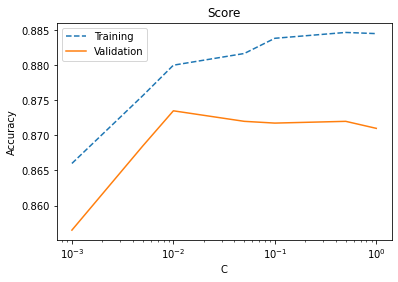

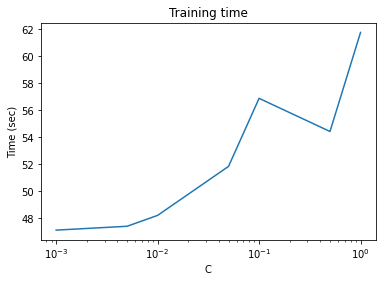

In [20]:
plot_grid_search(results, 'C', None, 'log')

Training on the original training set with params = {'C': 0.01}
Training time = 231.6 sec = 3.9 min
Training accuracy = 0.8777
Test accuracy = 0.8802


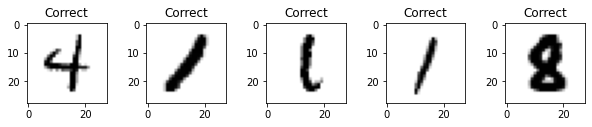

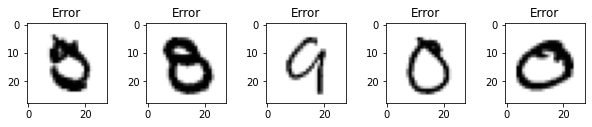

In [21]:
evaluate_model('My Linear SVM - small', model, results['best_params'], x_train_all_small, y_train_all_small, x_test, y_test)

#### 3.5 Linear SVM - small

Βελτιστοποίηση του sklearn.svm.SVC με linear kernel στο μικρό training set.

In [22]:
from sklearn import svm

param_dict = {
    'C': (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.)
}

model = svm.SVC(kernel='linear')
results = grid_search(model, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)


Best params = {'C': 0.05}
Maximum validation accuracy = 0.87325



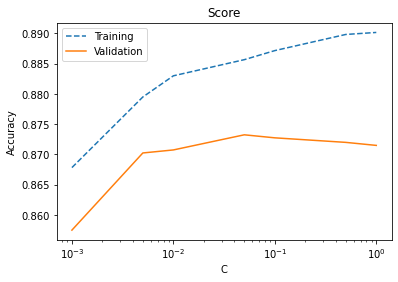

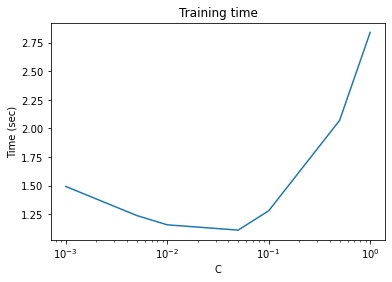

In [23]:
plot_grid_search(results, 'C', None, 'log')

Training on the original training set with params = {'C': 0.05}
Training time = 3.4 sec = 0.1 min
Training accuracy = 0.8831
Test accuracy = 0.8854


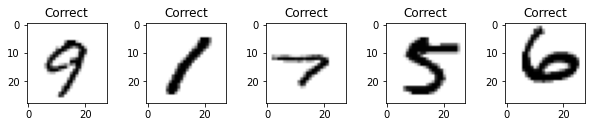

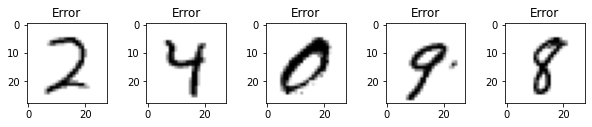

In [24]:
evaluate_model('Linear SVM - small', model, results['best_params'], x_train_all_small, y_train_all_small, x_test, y_test)

#### 3.6 Linear SVM

Βελτιστοποίηση του sklearn.svm.SVC με linear kernel σε ολόκληρο το training set.

In [25]:
from sklearn import svm

param_dict = {
    'C': (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.)
}

model = svm.SVC(kernel='linear')
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val)


Best params = {'C': 0.5}
Maximum validation accuracy = 0.88325



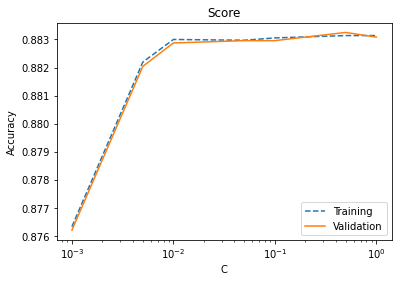

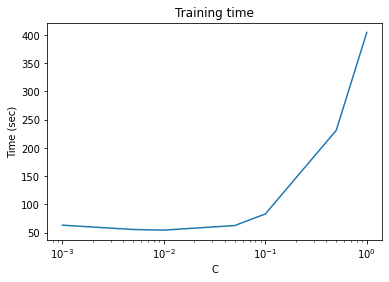

In [26]:
plot_grid_search(results, 'C', None, 'log')

Training on the original training set with params = {'C': 0.5}
Training time = 853.7 sec = 14.2 min
Training accuracy = 0.8836
Test accuracy = 0.8872


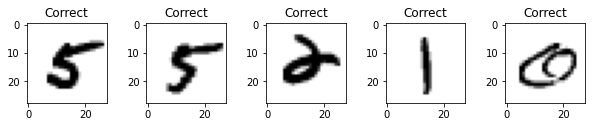

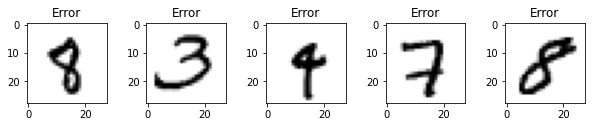

In [27]:
evaluate_model('Linear SVM', model, results['best_params'], x_train_all, y_train_all, x_test, y_test)

#### 3.7 My Polynomial SVM - small

Η βελτιστοποίηση του MySVM με polynomial kernel στο μικρο training set πραγματοποιείται ως προς τις παραμέτρους C και degree. Το degree είναι ο βαθμός του πολυωνύμου. Το gamma έχει την default τιμή 'scale' και υπολογίζεται ως gamma = 1/(n_features*X.var()).

Kernel: $ K(\mathbf{x}, \mathbf{x}') = (\gamma\langle\mathbf{x},\mathbf{x}'\rangle+r)^d $

In [28]:
from sklearn import svm

param_dict = {
    'C': (0.001, 0.01, 0.1, 1., 10., 100., 1000.),
    'degree': (2, 3, 4, 5)
}

model = MySVM(kernel='poly')
results = grid_search(model, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)


Best params = {'C': 10.0, 'degree': 3}
Maximum validation accuracy = 0.968



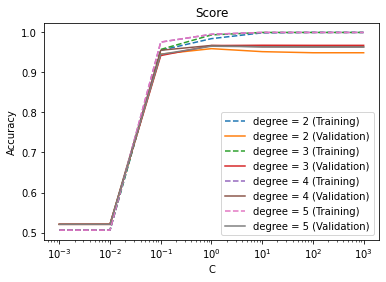

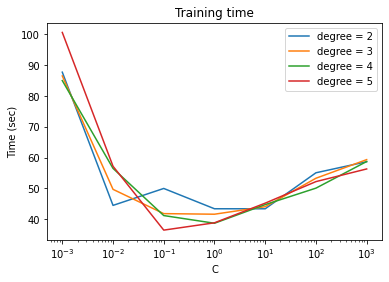

In [29]:
plot_grid_search(results, 'C', 'degree', 'log')

Training on the original training set with params = {'C': 10.0, 'degree': 3}
Training time = 167.0 sec = 2.8 min
Training accuracy = 0.9998
Test accuracy = 0.975


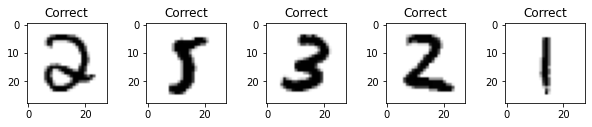

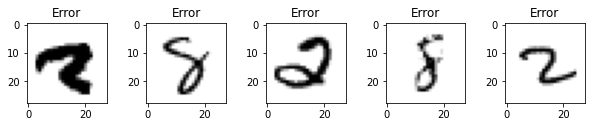

In [30]:
evaluate_model('My Polynomial SVM - small', model, results['best_params'], x_train_all_small, y_train_all_small, x_test, y_test)

#### 3.8 Polynomial SVM - small

Βελτιστοποίηση του sklearn.svm.SVC με polynomial kernel στο μικρο training set.

In [31]:
from sklearn import svm

param_dict = {
    'C': (0.001, 0.01, 0.1, 1., 10., 100., 1000.),
    'degree': (2, 3, 4, 5)
}

model = svm.SVC(kernel='poly')
results = grid_search(model, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)


Best params = {'C': 100.0, 'degree': 4}
Maximum validation accuracy = 0.97475



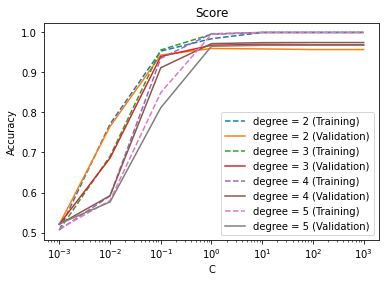

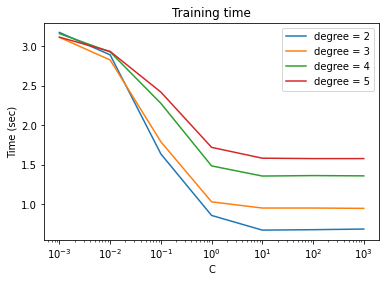

In [32]:
plot_grid_search(results, 'C', 'degree', 'log')

Training on the original training set with params = {'C': 100.0, 'degree': 4}
Training time = 3.3 sec = 0.1 min
Training accuracy = 1.0
Test accuracy = 0.9802


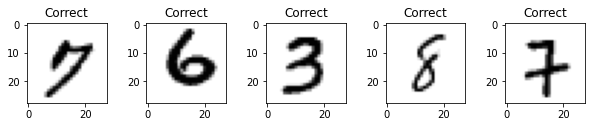

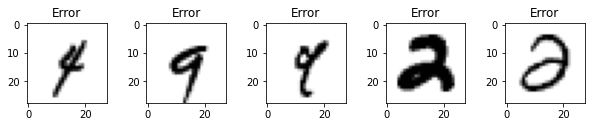

In [33]:
evaluate_model('Polynomial SVM - small', model, results['best_params'], x_train_all_small, y_train_all_small, x_test, y_test)

#### 3.9 Polynomial SVM

Βελτιστοποίηση του sklearn.svm.SVC με polynomial kernel σε ολόκληρο το training set.

In [34]:
from sklearn import svm

param_dict = {
    'C': (0.001, 0.01, 0.1, 1., 10., 100., 1000.),
    'degree': (2, 3, 4, 5)
}

model = svm.SVC(kernel='poly')
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val)


Best params = {'C': 1.0, 'degree': 4}
Maximum validation accuracy = 0.9882083333333334



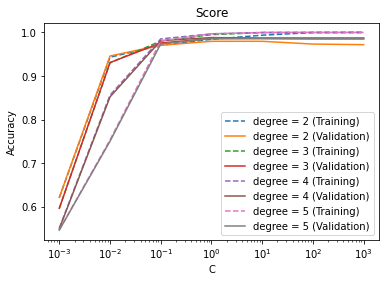

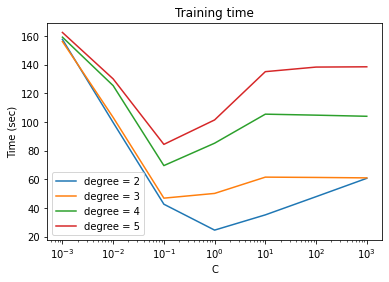

In [35]:
plot_grid_search(results, 'C', 'degree', 'log')

Training on the original training set with params = {'C': 1.0, 'degree': 4}
Training time = 193.3 sec = 3.2 min
Training accuracy = 0.9971833333333333
Test accuracy = 0.9908


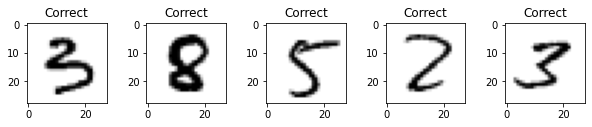

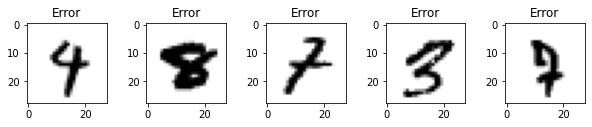

In [36]:
evaluate_model('Polynomial SVM', model, results['best_params'], x_train_all, y_train_all, x_test, y_test)

#### 3.10 My RBF SVM - small

Η βελτιστοποίηση του MySVM με rbf kernel πραγματοποιείται ως προς τις παραμέτρους C και gamma. Το gamma δείχνει πόσο μακριά φτάνει η επιρροή ενός παραδείγματος.

Kernel: $ K(\mathbf{x}, \mathbf{x}') = e^{-\gamma||\mathbf{x}-\mathbf{x}'||^2} $

In [37]:
param_dict = {
    'C': (0.001, 0.01, 0.1, 1., 10., 100.),
    'gamma': (0.01, 0.1, 1.)
}

model = MySVM(kernel='rbf')
results = grid_search(model, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)


Best params = {'C': 10.0, 'gamma': 0.1}
Maximum validation accuracy = 0.96475



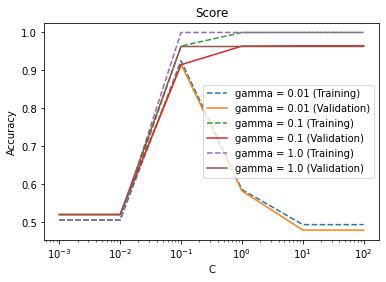

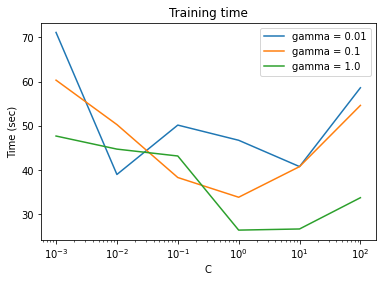

In [38]:
plot_grid_search(results, 'C', 'gamma', 'log')

Training on the original training set with params = {'C': 10.0, 'gamma': 0.1}
Training time = 161.6 sec = 2.7 min
Training accuracy = 1.0
Test accuracy = 0.977


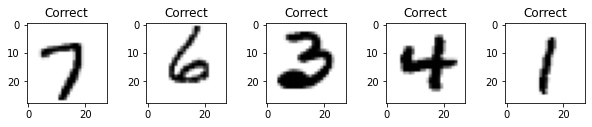

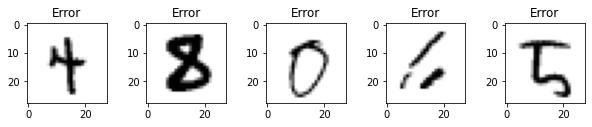

In [39]:
evaluate_model('My RBF SVM - small', model, results['best_params'], x_train_all_small, y_train_all_small, x_test, y_test)

#### 3.11 RBF SVM - small

Βελτιστοποίηση του sklearn.svm.SVC με rbf kernel στο μικρό training set.

In [40]:
param_dict = {
    'C': (0.001, 0.01, 0.1, 1., 10., 100.),
    'gamma': (0.01, 0.1, 1.)
}

model = svm.SVC(kernel='rbf')
results = grid_search(model, param_dict, x_train_small, y_train_small, x_val_small, y_val_small)


Best params = {'C': 100.0, 'gamma': 0.01}
Maximum validation accuracy = 0.97325



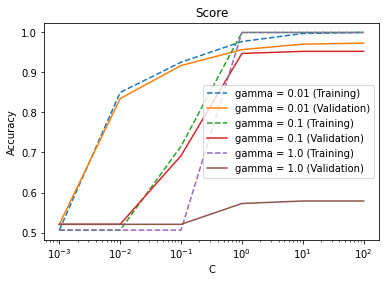

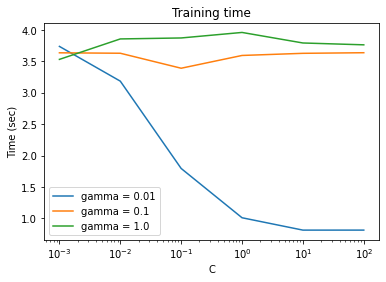

In [41]:
plot_grid_search(results, 'C', 'gamma', 'log')

Training on the original training set with params = {'C': 100.0, 'gamma': 0.01}
Training time = 1.9 sec = 0.0 min
Training accuracy = 1.0
Test accuracy = 0.9808


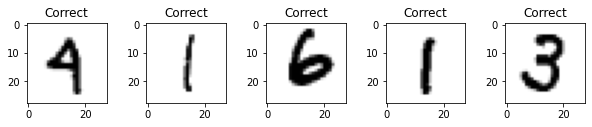

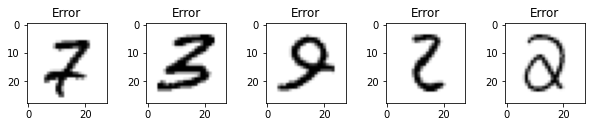

In [42]:
evaluate_model('RBF SVM - small', model, results['best_params'], x_train_all_small, y_train_all_small, x_test, y_test)

#### 3.12 RBF SVM

Βελτιστοποίηση του sklearn.svm.SVC με rbf kernel σε ολόκληρο το training set.

In [43]:
param_dict = {
    'C': (0.001, 0.01, 0.1, 1., 10., 100.),
    'gamma': (0.01, 0.1, 1.)
}

model = svm.SVC(kernel='rbf')
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val)


Best params = {'C': 10.0, 'gamma': 0.01}
Maximum validation accuracy = 0.988375



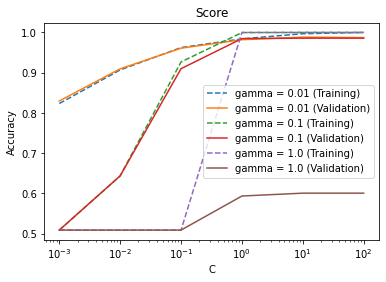

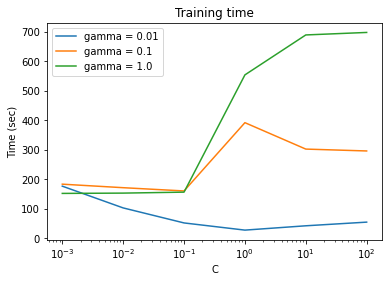

In [44]:
plot_grid_search(results, 'C', 'gamma', 'log')

Training on the original training set with params = {'C': 10.0, 'gamma': 0.01}
Training time = 118.8 sec = 2.0 min
Training accuracy = 0.9968666666666667
Test accuracy = 0.9905


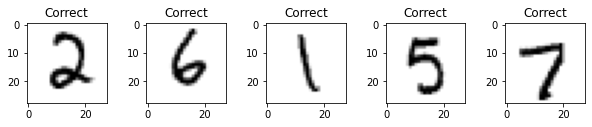

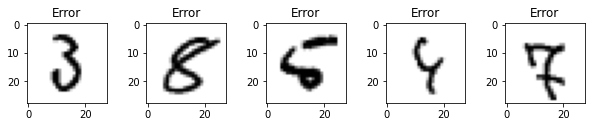

In [45]:
evaluate_model('RBF SVM', model, results['best_params'], x_train_all, y_train_all, x_test, y_test)

#### 3.13 Sigmoid SVM

Η βελτιστοποίηση του svm.SVC με sigmoid kernel πραγματοποιείται ως προς τις παραμέτρους C και gamma.

Kernel: $ K(\mathbf{x}, \mathbf{x}') = tanh(\gamma\langle\mathbf{x},\mathbf{x}'\rangle+r) $

In [46]:
param_dict = {
    'C': (0.001, 0.01, 0.1, 1., 10., 100.),
    'gamma': (0.001, 0.01, 0.1)
}

model = svm.SVC(kernel='sigmoid')
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val)


Best params = {'C': 10.0, 'gamma': 0.001}
Maximum validation accuracy = 0.8814166666666666



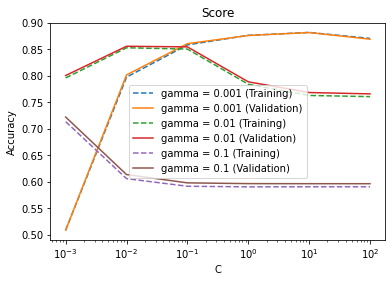

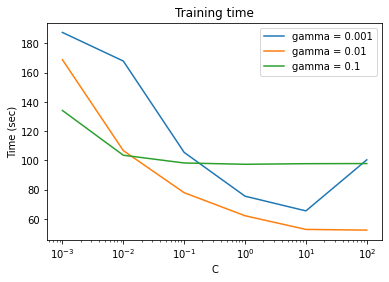

In [47]:
plot_grid_search(results, 'C', 'gamma', 'log')

Training on the original training set with params = {'C': 10.0, 'gamma': 0.001}
Training time = 186.4 sec = 3.1 min
Training accuracy = 0.8810333333333333
Test accuracy = 0.885


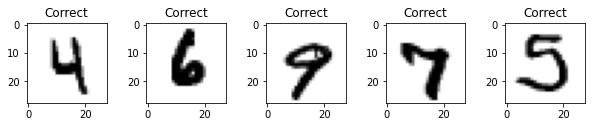

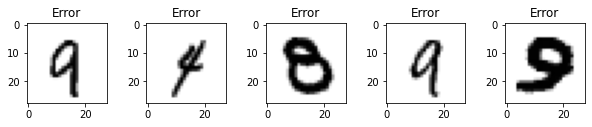

In [48]:
evaluate_model('Sigmoid SVM', model, results['best_params'], x_train_all, y_train_all, x_test, y_test)

#### 3.14 Nearest Neighbors

Η βελτιστοποίηση του sklearn.neighbors.KNeighborsClassifier πραγματοποιείται ως προς τις παραμέτρους n_neighbors και p. Στον πολυδιάστατο χώρο των χαρακτηριστικών οι k πλησιέστεροι γείτονες του κάθε δείγματος ψηφίζουν για να αποφασίσουν την κλάση στην οποία ανήκει. Για να βρεθούν οι πλησιέστεροι γείτονες χρησιμοποιείται η απόσταση minkowski:

$d_p(\mathbf{x}, \mathbf{y}) = \sqrt[p]{\sum_{i}|x_i-y_i|^p}$

In [49]:
from sklearn import neighbors

param_dict = {
    'n_neighbors': (1, 2, 5, 10),
    'p': (1, 2, 3)
}

model = neighbors.KNeighborsClassifier()
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val)


Best params = {'n_neighbors': 1, 'p': 2}
Maximum validation accuracy = 0.984625



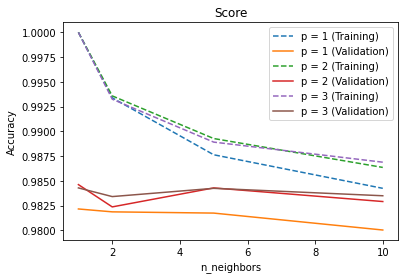

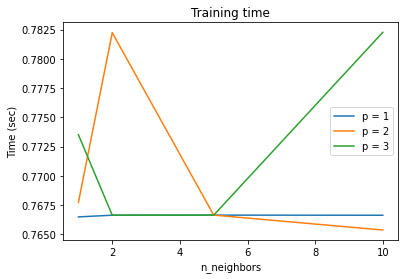

In [50]:
plot_grid_search(results, 'n_neighbors', 'p')

Training on the original training set with params = {'n_neighbors': 1, 'p': 2}
Training time = 1.3 sec = 0.0 min
Training accuracy = 1.0
Test accuracy = 0.9853


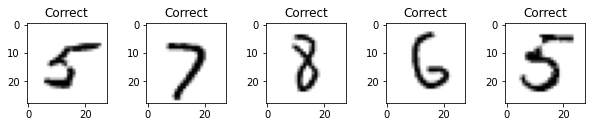

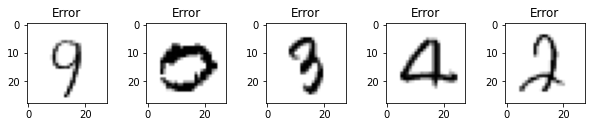

In [51]:
evaluate_model('Nearest Neighbors', model, results['best_params'], x_train_all, y_train_all, x_test, y_test)

#### 3.15 Nearest Class Centroid

Η βελτιστοποίηση του sklearn.neighbors.NearestCentroid πραγματοποιείται ως προς το shrink_threshold. Κάθε κλάση αντιπροσωπεύεται απο το centroid των μελών της.

In [52]:
param_dict = {
    'shrink_threshold': np.arange(0, 1.1, 0.1)
}

model = neighbors.NearestCentroid()
results = grid_search(model, param_dict, x_train, y_train, x_val, y_val)


Best params = {'shrink_threshold': 0.0}
Maximum validation accuracy = 0.8100416666666667



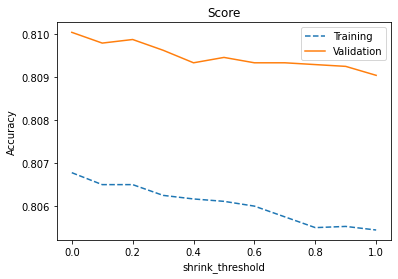

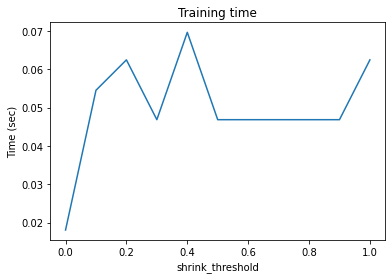

In [53]:
plot_grid_search(results, 'shrink_threshold')

Training on the original training set with params = {'shrink_threshold': 0.0}
Training time = 0.0 sec = 0.0 min
Training accuracy = 0.8080666666666667
Test accuracy = 0.8019


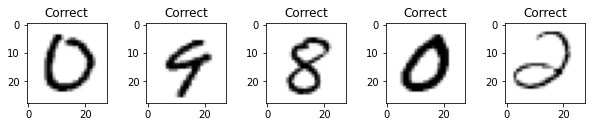

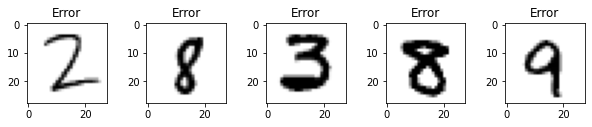

In [54]:
evaluate_model('Nearest Class Centroid', model, results['best_params'], x_train_all, y_train_all, x_test, y_test)

### 4. Σύνοψη αποτελεσμάτων

Συνοπτικά αποτελέσματα σε ολόκληρο το training set.

In [55]:
final_results_df = pd.DataFrame(final_results)
final_results_df = final_results_df.style.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
final_results_df.set_properties(**{'text-align': 'left'}).hide_index()

Classifier,Parameters,Training Accuracy,Test Accuracy,Training Time (sec)
Dummy Classifier,strategy = 'most_frequent',0.5084,0.5074,0
Linear SVM,C = 0.5000,0.8836,0.8872,853.7
Polynomial SVM,"C = 1.0000, degree = 4",0.9972,0.9908,193.3
RBF SVM,"C = 10.0000, gamma = 0.0100",0.9969,0.9905,118.8
Sigmoid SVM,"C = 10.0000, gamma = 0.0010",0.8810,0.8850,186.4
Nearest Neighbors,"n_neighbors = 1, p = 2",1.0000,0.9853,1.3
Nearest Class Centroid,shrink_threshold = 0.0000,0.8081,0.8019,0.0


Συνοπτικά αποτελέσματα στο μικρό training set.

In [56]:
final_results_df = pd.DataFrame(final_results_small)
final_results_df = final_results_df.style.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
final_results_df.set_properties(**{'text-align': 'left'}).hide_index()

Classifier,Parameters,Training Accuracy,Test Accuracy,Training Time (sec)
My Linear SVM - small,C = 0.0100,0.8777,0.8802,231.6
Linear SVM - small,C = 0.0500,0.8831,0.8854,3.4
My Polynomial SVM - small,"C = 10.0000, degree = 3",0.9998,0.9750,167.0
Polynomial SVM - small,"C = 100.0000, degree = 4",1.0000,0.9802,3.3
My RBF SVM - small,"C = 10.0000, gamma = 0.1000",1.0000,0.9770,161.6
RBF SVM - small,"C = 100.0000, gamma = 0.0100",1.0000,0.9808,1.9
